## Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Embedding,LSTM,Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from pythainlp.corpus.common import thai_stopwords
from pythainlp import word_tokenize
from wordcloud import WordCloud, STOPWORDS
import re

## Import Data

In [2]:
df_train = pd.read_parquet('train-00000-of-00001.parquet') 

In [3]:
df_train.head()

,texts,category
0,ไปจองมาแล้วนาจา Mitsubishi Attrage ได้หลังสงกร...,1
1,เปิดศักราชใหม่! นายกฯ แถลงข่าวก่อนการแข่งขันศึ...,1
2,บัตรสมาชิกลดได้อีกไหมคับ,1
3,สนใจ new mazda2ครับ,1
4,😍😍,0


In [4]:
df_train['category'].value_counts()

category
1    11795
2     5491
0     3866
3      476
Name: count, dtype: int64

In [5]:
df_train.shape

(21628, 2)

In [6]:
df_val = pd.read_parquet('validation-00000-of-00001.parquet')

In [7]:
df_val.head()

,texts,category
0,วันที่6/3/61 เสียอารมณ์มาเร้ย. อาหารช้ามากกกกก...,2
1,ยี่ห้อนี่ เขาชอบตั้งชื่อ ลงท้ายด้วย สระอา เทีย...,0
2,สองวันสุดท้าย! ใครอยู่แถวแฟชั่น ไอส์แลนด์ มาร่...,1
3,น้องแสงโสมอี้บ๋อ กะว่าน้องโซดา น้ำแข็งดี เอ๊ะห...,0
4,สนามบินไหนไม่แพงล่ะครับบ ชางฮี เชคแลบก๊ก เจเอฟ...,1


In [8]:
df_val['category'].value_counts()

category
1    1291
2     637
0     434
3      42
Name: count, dtype: int64

In [9]:
df_val.shape

(2404, 2)

In [10]:
df_test = pd.read_parquet('test-00000-of-00001.parquet') 

In [11]:
df_test.head()

,texts,category
0,ซื้อแต่ผ้าอนามัยแบบเย็นมาค่ะ แบบว่าอีห่ากูนอนไ...,2
1,ครับ #phithanbkk,1
2,การด่าไปเหมือนได้บรรเทาความเครียดเฉยๆ แต่บีทีเ...,2
3,Cf clarins 5 ขวด 2850,1
4,ทานได้ค่ะ น้ำซุป MK ต้มมาจากหัวผักกาด ซีอิ้วขา...,1


In [12]:
df_test['category'].value_counts()

category
1    1453
2     683
0     478
3      57
Name: count, dtype: int64

In [13]:
df_test.shape

(2671, 2)

This project remove category 3 due to insufficient data for analysis and being outside the scope of interest.

In [14]:
df_train = df_train[df_train['category'] != 3]

In [15]:
df_val = df_val[df_val['category'] != 3]

In [16]:
df_test = df_test[df_test['category'] != 3]

## EDA

In [17]:
df_train['text_length'] = df_train['texts'].apply(len)

In [18]:
df_val['text_length'] = df_val['texts'].apply(len)

In [19]:
df_test['text_length'] = df_test['texts'].apply(len)

In [20]:
df_train.head()

,texts,category,text_length
0,ไปจองมาแล้วนาจา Mitsubishi Attrage ได้หลังสงกร...,1,162
1,เปิดศักราชใหม่! นายกฯ แถลงข่าวก่อนการแข่งขันศึ...,1,75
2,บัตรสมาชิกลดได้อีกไหมคับ,1,24
3,สนใจ new mazda2ครับ,1,19
4,😍😍,0,2


In [21]:
df_val.head()

,texts,category,text_length
0,วันที่6/3/61 เสียอารมณ์มาเร้ย. อาหารช้ามากกกกก...,2,147
1,ยี่ห้อนี่ เขาชอบตั้งชื่อ ลงท้ายด้วย สระอา เทีย...,0,93
2,สองวันสุดท้าย! ใครอยู่แถวแฟชั่น ไอส์แลนด์ มาร่...,1,371
3,น้องแสงโสมอี้บ๋อ กะว่าน้องโซดา น้ำแข็งดี เอ๊ะห...,0,85
4,สนามบินไหนไม่แพงล่ะครับบ ชางฮี เชคแลบก๊ก เจเอฟ...,1,555


In [22]:
df_test.head()

,texts,category,text_length
0,ซื้อแต่ผ้าอนามัยแบบเย็นมาค่ะ แบบว่าอีห่ากูนอนไ...,2,51
1,ครับ #phithanbkk,1,16
2,การด่าไปเหมือนได้บรรเทาความเครียดเฉยๆ แต่บีทีเ...,2,82
3,Cf clarins 5 ขวด 2850,1,21
4,ทานได้ค่ะ น้ำซุป MK ต้มมาจากหัวผักกาด ซีอิ้วขา...,1,65


In [23]:
df_train['text_length'].describe()

count    21152.000000
mean        90.796379
std        150.656154
min          1.000000
25%         19.000000
50%         39.000000
75%        100.000000
max       1997.000000
Name: text_length, dtype: float64

In [24]:
df_val['text_length'].describe()

count    2362.000000
mean       90.019898
std       143.459643
min         1.000000
25%        19.000000
50%        41.000000
75%        99.750000
max      1708.000000
Name: text_length, dtype: float64

In [25]:
df_test['text_length'].describe()

count    2614.000000
mean       91.354246
std       153.477339
min         1.000000
25%        19.000000
50%        39.000000
75%        99.000000
max      1978.000000
Name: text_length, dtype: float64

Use FacetGrid from the seaborn library to create a grid of histograms of text length based on their category

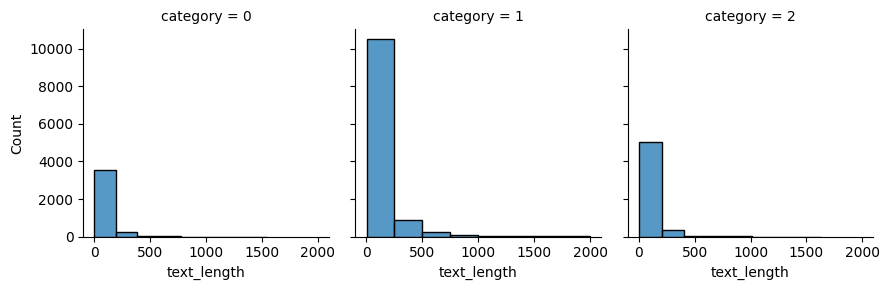

In [26]:
g = sns.FacetGrid(df_train,col='category')
g.map_dataframe(sns.histplot,x='text_length',bins=8)
plt.show()

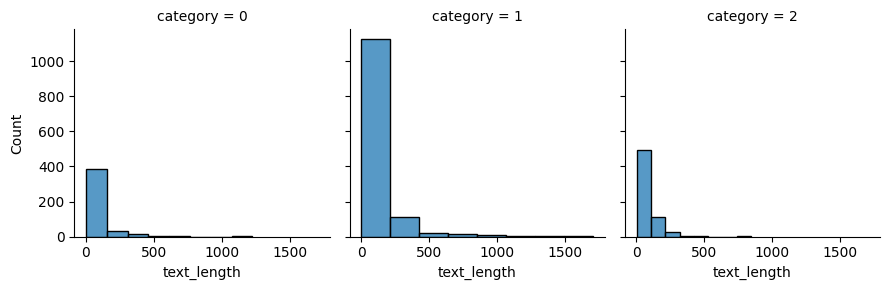

In [27]:
g = sns.FacetGrid(df_val,col='category')
g.map_dataframe(sns.histplot,x='text_length',bins=8)
plt.show()

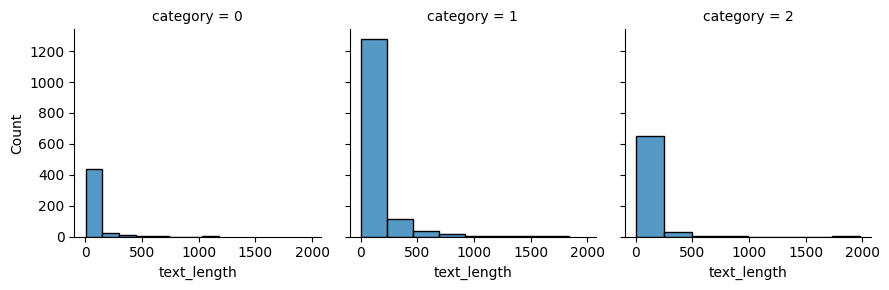

In [28]:
g = sns.FacetGrid(df_test,col='category')
g.map_dataframe(sns.histplot,x='text_length',bins=8)
plt.show()

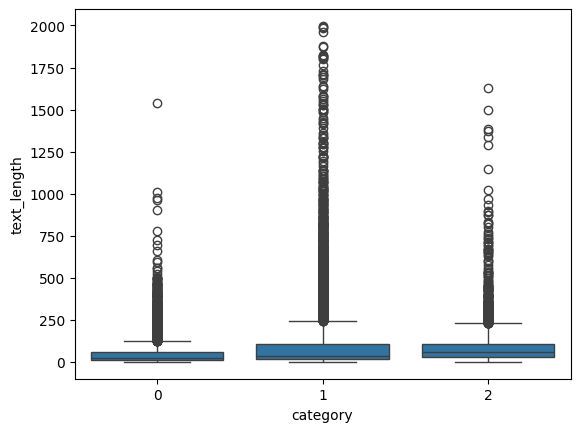

In [29]:
sns.boxplot(data=df_train,x='category',y='text_length')
plt.show()

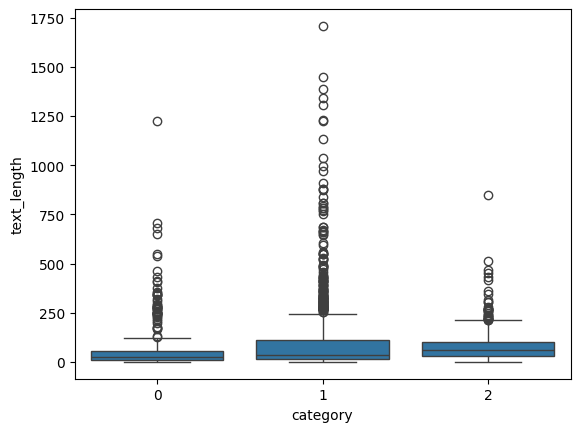

In [30]:
sns.boxplot(data=df_val,x='category',y='text_length')
plt.show()

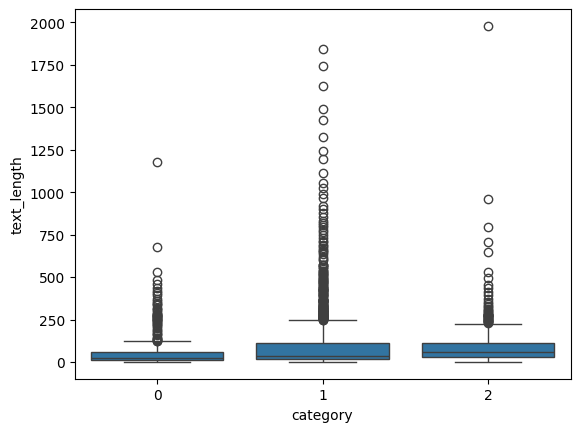

In [31]:
sns.boxplot(data=df_test,x='category',y='text_length')
plt.show()

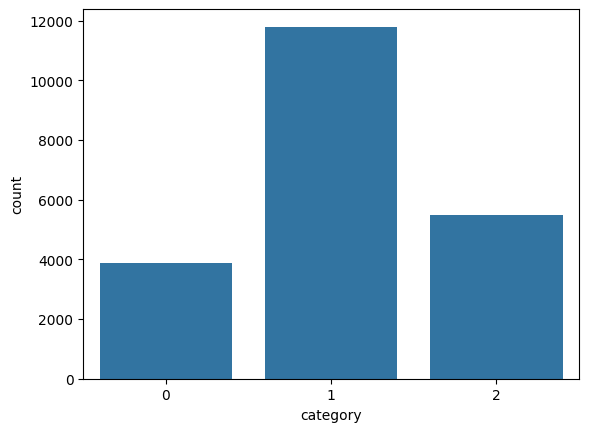

In [32]:
sns.countplot(data=df_train,x='category')
plt.show()

## Data Preprocessing

### Remove stopword and then tokenization

In [33]:
stopwords = list(thai_stopwords())
stopwords[:10]

['ค่อนข้าง',
 'จำพวก',
 'ตั้ง',
 'เลย',
 'จึง',
 'ก็แค่',
 'คราวหลัง',
 'จริง',
 'ที่แท้จริง',
 'ไร']

In [34]:
def text_preprocess(texts):
    cleaned_text = "".join(text for text in texts if text not in (".",";",":","!",'"',"ๆ","ฯ"))
    cleaned_text = word_tokenize(cleaned_text)
    cleaned_text = " ".join(word for word in cleaned_text)
    cleaned_text = " ".join(word for word in cleaned_text.split() if word.lower not in stopwords)
    return cleaned_text

In [35]:
df_train['texts_tokenized'] = df_train['texts'].apply(text_preprocess)
df_val['texts_tokenized'] = df_val['texts'].apply(text_preprocess)
df_test['texts_tokenized'] = df_test['texts'].apply(text_preprocess)

In [36]:
df_train.head()

,texts,category,text_length,texts_tokenized
0,ไปจองมาแล้วนาจา Mitsubishi Attrage ได้หลังสงกร...,1,162,ไป จอง มา แล้ วนา จา Mitsubishi Attrage ได้ หล...
1,เปิดศักราชใหม่! นายกฯ แถลงข่าวก่อนการแข่งขันศึ...,1,75,เปิด ศักราช ใหม่ นายก แถลงข่าว ก่อน การแข่งขัน...
2,บัตรสมาชิกลดได้อีกไหมคับ,1,24,บัตรสมาชิก ลด ได้ อีก ไหม คับ
3,สนใจ new mazda2ครับ,1,19,สนใจ new mazda 2 ครับ
4,😍😍,0,2,😍😍


In [37]:
df_val.head()

,texts,category,text_length,texts_tokenized
0,วันที่6/3/61 เสียอารมณ์มาเร้ย. อาหารช้ามากกกกก...,2,147,วันที่ 6 /3/61 เสียอารมณ์ มา เร้ย อาหาร ช้า มา...
1,ยี่ห้อนี่ เขาชอบตั้งชื่อ ลงท้ายด้วย สระอา เทีย...,0,93,ยี่ห้อ นี่ เขา ชอบ ตั้งชื่อ ลงท้าย ด้วย สระ อา...
2,สองวันสุดท้าย! ใครอยู่แถวแฟชั่น ไอส์แลนด์ มาร่...,1,371,สอง วันสุดท้าย ใคร อยู่ แถว แฟชั่น ไอส์แลนด์ ม...
3,น้องแสงโสมอี้บ๋อ กะว่าน้องโซดา น้ำแข็งดี เอ๊ะห...,0,85,น้อง แสงโสม อี้ บ๋อ กะ ว่า น้อง โซดา น้ำแข็ง ด...
4,สนามบินไหนไม่แพงล่ะครับบ ชางฮี เชคแลบก๊ก เจเอฟ...,1,555,สนามบิน ไหน ไม่ แพง ล่ะ ครับ บ ชา ง ฮี เชค แลบ...


In [38]:
df_test.head()

,texts,category,text_length,texts_tokenized
0,ซื้อแต่ผ้าอนามัยแบบเย็นมาค่ะ แบบว่าอีห่ากูนอนไ...,2,51,ซื้อ แต่ ผ้าอนามัย แบบ เย็น มา ค่ะ แบบ ว่า อี ...
1,ครับ #phithanbkk,1,16,ครับ #phithanbkk
2,การด่าไปเหมือนได้บรรเทาความเครียดเฉยๆ แต่บีทีเ...,2,82,การ ด่า ไป เหมือน ได้ บรรเทา ความเครียด เฉย แต...
3,Cf clarins 5 ขวด 2850,1,21,Cf clarins 5 ขวด 2850
4,ทานได้ค่ะ น้ำซุป MK ต้มมาจากหัวผักกาด ซีอิ้วขา...,1,65,ทาน ได้ ค่ะ น้ำ ซุป MK ต้ม มาจาก หัวผักกาด ซีอ...


### Check frequency of word

Word Cloud of Positive word in training dataset

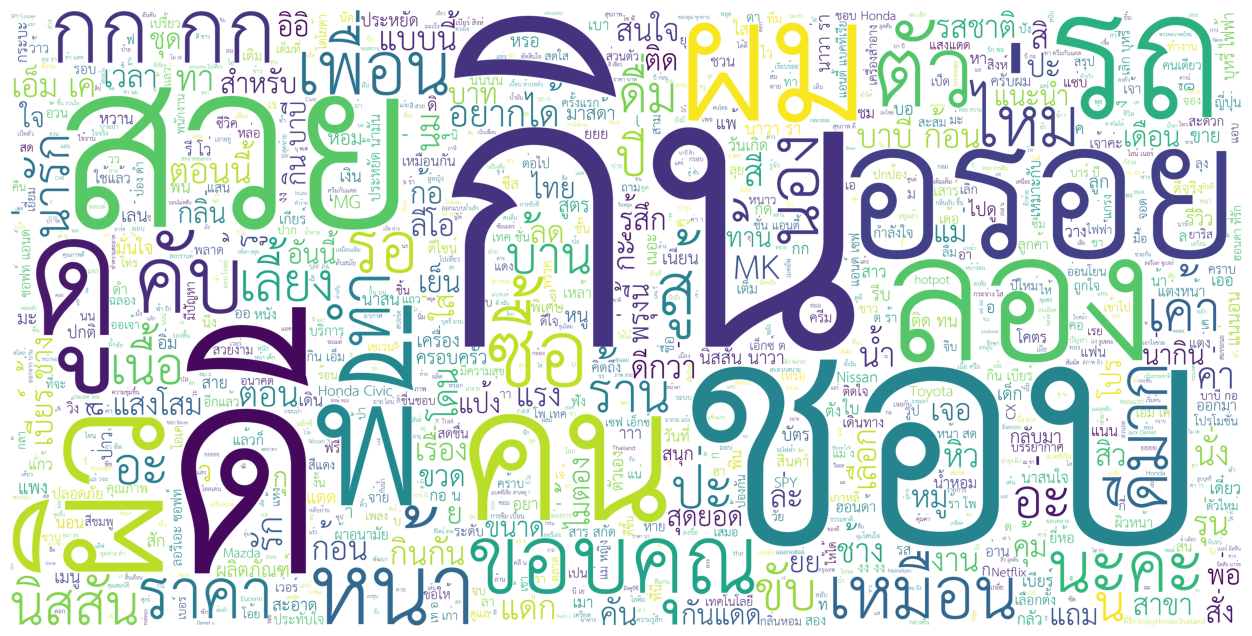

In [39]:
df_pos = df_train[df_train['category'] == 0]
pos_words = " ".join(text for text in df_pos['texts_tokenized'])
regex_pattern =  r"[ก-๙a-zA-Z0-9]+"   
font = 'THSarabunNew.ttf'

wordcloud = WordCloud(stopwords=stopwords,background_color='white',font_path=font,max_words=1000,
                      width=4000,height=2000,regexp=regex_pattern).generate(pos_words)

plt.figure(figsize = (16,8))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()


Word Cloud of Negative word in training dataset

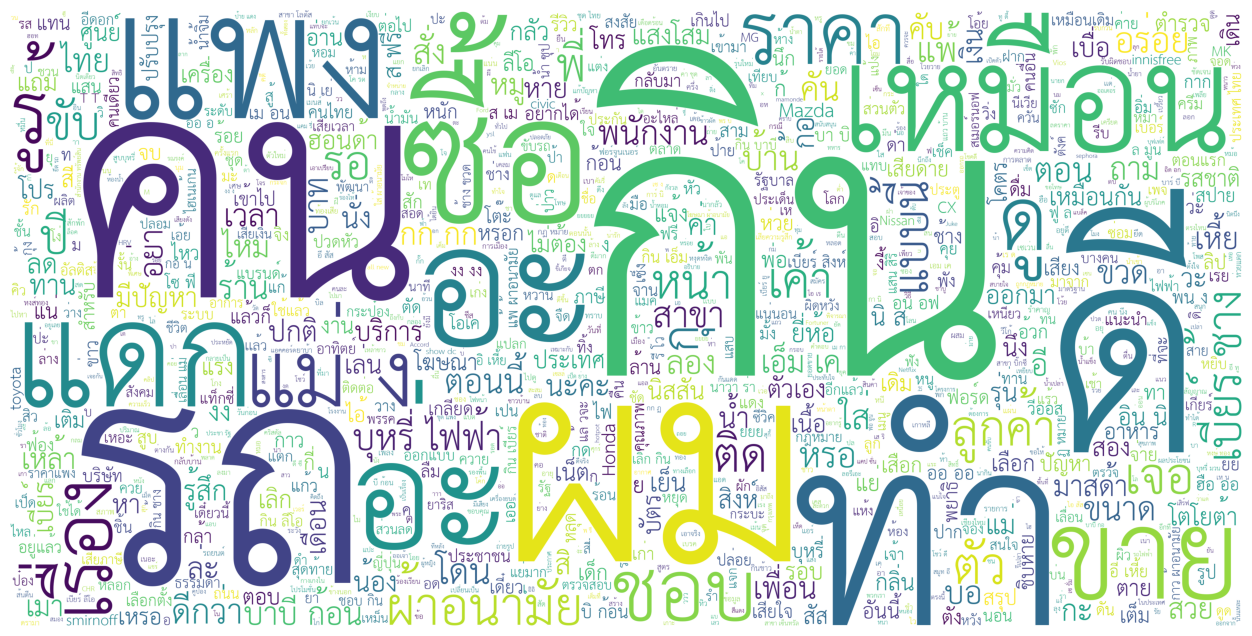

In [40]:
df_pos = df_train[df_train['category'] == 2]
neg_words = " ".join(text for text in df_pos['texts_tokenized'])
regex_pattern =  r"[ก-๙a-zA-Z0-9]+"        
font = 'THSarabunNew.ttf'

wordcloud = WordCloud(stopwords=stopwords,background_color='white',font_path=font,max_words=1000,
                      width=4000,height=2000,regexp=regex_pattern).generate(neg_words)

plt.figure(figsize = (16,8))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()


## Convert train and test data to sequences and Padding it.

In [41]:
max_len = df_train['texts_tokenized'].apply(lambda x: len(x.split())).max() 

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train["texts_tokenized"])
# Convert train and test data to sequences for use in neural network
train_sequences = tokenizer.texts_to_sequences(df_train["texts_tokenized"])
val_sequences = tokenizer.texts_to_sequences(df_val["texts_tokenized"])
test_sequences = tokenizer.texts_to_sequences(df_test["texts_tokenized"])

# Pad sequence to make all input have same length of word
X_train = pad_sequences(train_sequences, maxlen=max_len)
X_val = pad_sequences(val_sequences, maxlen=max_len)
X_test = pad_sequences(test_sequences, maxlen=max_len)

# Convert to categorical value
y_train = to_categorical(df_train['category'], num_classes=3)
y_val = to_categorical(df_val['category'], num_classes=3)
y_test = to_categorical(df_test['category'], num_classes=3)


## Create LSTM Model

In [42]:
vocab_size = len(tokenizer.word_index) + 1

In [43]:
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=vocab_size,output_dim=256,input_length=max_len))
lstm_model.add(LSTM(128,dropout=0.4))
lstm_model.add(Dense(3,activation='softmax'))


In [44]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 478, 256)          6668032   
                                                                 
 lstm (LSTM)                 (None, 128)               197120    
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                                 
Total params: 6,865,539
Trainable params: 6,865,539
Non-trainable params: 0
_________________________________________________________________


In [45]:
lstm_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [46]:
early_stop = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=3)

In [47]:
history = lstm_model.fit(X_train,y_train,
              validation_data = (X_val,y_val),
              epochs=10,
              callbacks=[early_stop],
            )

Epoch 1/10
661/661 [==============================] - 53s 73ms/step - loss: 0.7471 - accuracy: 0.6850 - val_loss: 0.6909 - val_accuracy: 0.7079
Epoch 2/10
661/661 [==============================] - 51s 77ms/step - loss: 0.5400 - accuracy: 0.7792 - val_loss: 0.6924 - val_accuracy: 0.7058
Epoch 3/10
661/661 [==============================] - 52s 78ms/step - loss: 0.4124 - accuracy: 0.8337 - val_loss: 0.7851 - val_accuracy: 0.7062
Epoch 4/10
661/661 [==============================] - 52s 79ms/step - loss: 0.3197 - accuracy: 0.8725 - val_loss: 0.8257 - val_accuracy: 0.7011
Epoch 4: early stopping


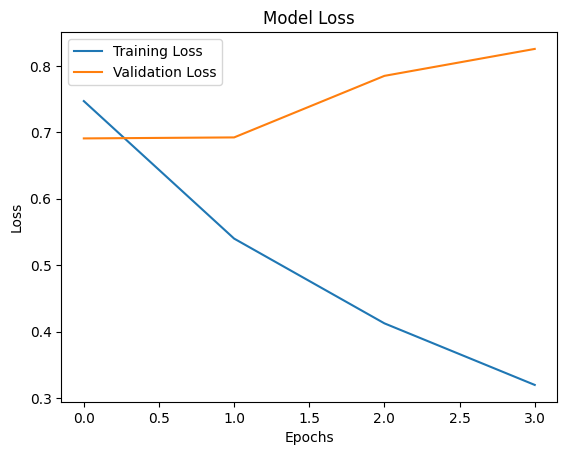

In [48]:
model_loss = pd.DataFrame(lstm_model.history.history)

plt.plot(model_loss['loss'], label='Training Loss')
plt.plot(model_loss['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

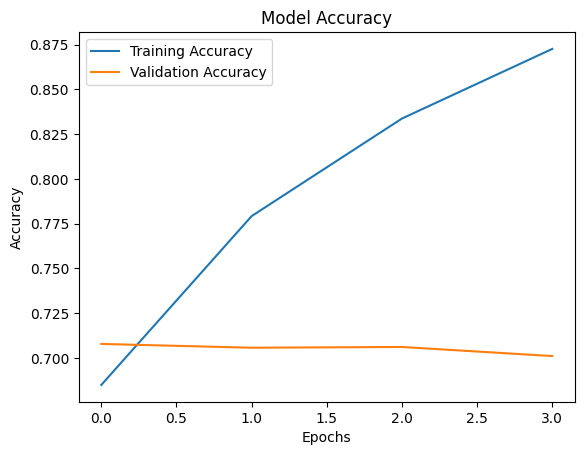

In [49]:
plt.plot(model_loss['accuracy'], label='Training Accuracy')
plt.plot(model_loss['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [50]:
predictions = lstm_model.predict(X_test)

82/82 [==============================] - 3s 26ms/step


## Evaluate model

In [51]:
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)
print(classification_report(true_classes, predicted_classes))

              precision    recall  f1-score   support

           0       0.54      0.41      0.47       478
           1       0.74      0.78      0.76      1453
           2       0.70      0.74      0.72       683

    accuracy                           0.70      2614
   macro avg       0.66      0.64      0.65      2614
weighted avg       0.69      0.70      0.69      2614



## Save LSTM model

In [52]:
lstm_model.save('lstm_model.h5')

## Testing Model with some input

In [53]:
sentiment_labels = {
    0: 'Positive',
    1: 'Neutral',
    2: 'Negative'
    # Add more labels if you have additional classes
}

def predict_sentiment(review):
    #tokenize and pad
    review = text_preprocess(review) 
    sequence = tokenizer.texts_to_sequences([review])
    padded_sequence = pad_sequences(sequence,maxlen=2000)
    prediction = lstm_model.predict(padded_sequence)
    sentiment_index = np.argmax(prediction)
    sentiment = sentiment_labels.get(sentiment_index)
    return sentiment
    


In [54]:
predict_sentiment('ชอบกินอะอร่อยดี')

1/1 [==============================] - 1s 532ms/step


'Positive'

In [55]:
predict_sentiment('นอยมากวันนี้โครตเซ็ง')

1/1 [==============================] - 0s 103ms/step


'Negative'

In [56]:
predict_sentiment('โครตไม่ชอบอันนี้เลย แย่มาก')

1/1 [==============================] - 0s 95ms/step


'Negative'

In [57]:
predict_sentiment('ฟินมากมีความสุขสุดๆเลยวันนี้')

1/1 [==============================] - 0s 83ms/step


'Positive'

# Conclusion

The current models exhibit slightly low accuracy, which can be attributed to the complexities of processing social media content in the Thai language, as well as instances of overfitting. To address these issues, I recommend implementing hyperparameter tuning, along with the incorporation of dropout and regularization techniques, to enhance model accuracy.